In [1]:
import csv
import matplotlib.pyplot as plt 
from matplotlib import cm
import pandas as pd
import numpy as np
import os

import scipy.stats

import statsmodels.stats.multitest
fdr = statsmodels.stats.multitest.fdrcorrection

import stats_utils
import plot_utils

get_moving_average = stats_utils.get_moving_average
mixed_effect_model = stats_utils.mixed_effect_model

# this should be your main project folder (startingblurry), one level up from "analysis"
root = os.path.dirname(os.getcwd())

#### Load all the data

In [2]:
n_epochs = 150; 
n_conds = 4;
trials = np.arange(1,11);
n_trials = len(trials)

# the first dimension of these arrays is the condition
# (image type)
dat_trn_col = np.zeros((n_conds, len(trials), n_epochs),dtype=float)
dat_val_col = np.zeros((n_conds, len(trials), n_epochs),dtype=float)

dat_trn_bw = np.zeros((n_conds, len(trials), n_epochs),dtype=float)
dat_val_bw = np.zeros((n_conds, len(trials), n_epochs),dtype=float)


for ti, tt in enumerate(trials):
    
    filename = os.path.join(root, 'trials', 'ColoredImgNet', \
                        '%d'%tt, 'trainingLogColoredModel.csv')    
    dat = pd.read_csv(filename)
    dat_trn_col[0,ti,:] = np.array(dat)[0:n_epochs,1]
    dat_val_col[0,ti,:] = np.array(dat)[0:n_epochs,2]
    
    filename = os.path.join(root, 'trials', 'ColoredImgNet', \
                        '%d'%tt, 'trainingLogColoredNoBlurModel.csv')    
    dat = pd.read_csv(filename)
    dat_trn_col[1,ti,:] = np.array(dat)[0:n_epochs,1]
    dat_val_col[1,ti,:] = np.array(dat)[0:n_epochs,2]
    
    filename = os.path.join(root, 'trials', 'ColoredImgNet', \
                        '%d'%tt, 'trainingLogColoredLinearBlurModel.csv')    
    dat = pd.read_csv(filename)
    dat_trn_col[2,ti,:] = np.array(dat)[0:n_epochs,1]
    dat_val_col[2,ti,:] = np.array(dat)[0:n_epochs,2]
    
    filename = os.path.join(root, 'trials', 'ColoredImgNet', \
                        '%d'%tt, 'trainingLogColoredNonLinearBlurModel2.csv')    
    dat = pd.read_csv(filename)
    dat_trn_col[3,ti,:] = np.array(dat)[0:n_epochs,1]
    dat_val_col[3,ti,:] = np.array(dat)[0:n_epochs,2]
    
    
    
    filename = os.path.join(root, 'trials', 'BWImgNet', \
                        '%d'%tt, 'trainingLogBWModel.csv')    
    dat = pd.read_csv(filename)
    dat_trn_bw[0,ti,:] = np.array(dat)[0:n_epochs,1]
    dat_val_bw[0,ti,:] = np.array(dat)[0:n_epochs,2]
    
    filename = os.path.join(root, 'trials', 'BWImgNet', \
                        '%d'%tt, 'trainingLogBWNoBlurModel.csv')    
    dat = pd.read_csv(filename)
    dat_trn_bw[1,ti,:] = np.array(dat)[0:n_epochs,1]
    dat_val_bw[1,ti,:] = np.array(dat)[0:n_epochs,2]
    
    filename = os.path.join(root, 'trials', 'BWImgNet', \
                        '%d'%tt, 'trainingLogBWLinearBlurModel.csv')    
    dat = pd.read_csv(filename)
    dat_trn_bw[2,ti,:] = np.array(dat)[0:n_epochs,1]
    dat_val_bw[2,ti,:] = np.array(dat)[0:n_epochs,2]
    
    filename = os.path.join(root, 'trials', 'BWImgNet', \
                        '%d'%tt, 'trainingLogBWNonLinearBlurModel2.csv')    
    dat = pd.read_csv(filename)
    dat_trn_bw[3,ti,:] = np.array(dat)[0:n_epochs,1]
    dat_val_bw[3,ti,:] = np.array(dat)[0:n_epochs,2]
    

#### make some names and colors for the plots

In [3]:
cond_names = ['scratch','pretrain_noblur', 'pretrain_blur1', 'pretrain_blur2']
gray_colors = cm.gray(np.linspace(0,1,4))[[1,2],:]
blue_colors = cm.Blues(np.linspace(0,1,8))[[6,4],:]
green_colors = cm.Greens(np.linspace(0,1,8))[[6,4],:]

cond_colors = np.concatenate([gray_colors, blue_colors[1:,:], green_colors[1:,:]], axis=0)

# # 6 possible pairwise comparisons here
conds_compare = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]
cond_comparisons = ['%s vs %s'%(cond_names[cc[0]], cond_names[cc[1]]) for cc in conds_compare]


#### perform smoothing, compute estimated learning rate
learning rate = approximate slope of accuracy at each timepoint


In [4]:
# do smoothing over time, within each trial and each condition separately

window_size=20;

smoothed_trn_bw = np.array([[get_moving_average(dat_trn_bw[cc,ii,:], window_size) \
                                   for ii in range(n_trials)] for cc in range(n_conds)])
smoothed_val_bw = np.array([[get_moving_average(dat_val_bw[cc,ii,:], window_size) \
                                   for ii in range(n_trials)] for cc in range(n_conds)])
smoothed_trn_col = np.array([[get_moving_average(dat_trn_col[cc,ii,:], window_size) \
                                   for ii in range(n_trials)] for cc in range(n_conds)])
smoothed_val_col = np.array([[get_moving_average(dat_val_col[cc,ii,:], window_size) \
                                   for ii in range(n_trials)] for cc in range(n_conds)])

n_epochs_smoothed = smoothed_trn_bw.shape[2]
# once the data is smoothed, the actual epoch corresponding to each datapt is different.
# we can get new epoch number by averaging the old epoch sequence
# epochs_smoothed = get_moving_average(np.arange(n_epochs), window_size)
epochs_smoothed = np.arange(n_epochs_smoothed)

# compute learning rate: difference in acc every epoch.
lr_trn_bw = np.diff(smoothed_trn_bw, axis=2)
lr_val_bw = np.diff(smoothed_val_bw, axis=2)
lr_trn_col = np.diff(smoothed_trn_col, axis=2)
lr_val_col = np.diff(smoothed_val_col, axis=2)

# smooth these values over time (again)
lr_window_size = 20;

lr_trn_smoothed_bw = np.array([[get_moving_average(lr_trn_bw[cc,ii,:], window_size=lr_window_size) \
                            for ii in range(n_trials)] for cc in range(n_conds)])
lr_val_smoothed_bw = np.array([[get_moving_average(lr_val_bw[cc,ii,:], window_size=lr_window_size) \
                            for ii in range(n_trials)] for cc in range(n_conds)])
lr_trn_smoothed_col = np.array([[get_moving_average(lr_trn_col[cc,ii,:], window_size=lr_window_size) \
                            for ii in range(n_trials)] for cc in range(n_conds)])
lr_val_smoothed_col = np.array([[get_moving_average(lr_val_col[cc,ii,:], window_size=lr_window_size) \
                            for ii in range(n_trials)] for cc in range(n_conds)])

# get the correct epoch numbers for smoothed learning rate estimates
epochs_lr_smoothed = np.arange(n_epochs_smoothed-1)+0.5
# epochs_lr_smoothed = get_moving_average(epochs_smoothed[0:-1], window_size=window_size)
n_epochs_lr_smoothed = len(epochs_lr_smoothed)

#### Mixed effects models
test for difference over multiple epochs, using sliding window

Note this cell is very slow, so I saved the results out to a .npy file

In [6]:
epoch_window_size=20
epoch_start_values = np.arange(0,n_epochs_smoothed-epoch_window_size,1)

epoch_ranges = [np.arange(ee, np.minimum(ee+epoch_window_size, n_epochs_smoothed)) \
                    for ee in epoch_start_values]
epoch_centers = [epochs_smoothed[int(np.mean(ee))] for ee in epoch_ranges]

coeffs_bw = np.zeros((len(epoch_start_values),6))
pvals_bw = np.zeros((len(epoch_start_values),6))

coeffs_lr_bw = np.zeros((len(epoch_start_values)-1,6))
pvals_lr_bw = np.zeros((len(epoch_start_values)-1,6))

coeffs_col = np.zeros((len(epoch_start_values),6))
pvals_col = np.zeros((len(epoch_start_values),6))

coeffs_lr_col = np.zeros((len(epoch_start_values)-1,6))
pvals_lr_col = np.zeros((len(epoch_start_values)-1,6))


for ee, epoch_range in enumerate(epoch_ranges):
    
    for cc, conds in enumerate(conds_compare):
    
        # test accuracy values
        coeff_condition, pval_condition =  mixed_effect_model(dat=smoothed_val_bw, \
                                                         conds_compare=conds, \
                                                         epoch_range=epoch_range)
        coeffs_bw[ee,cc] = coeff_condition
        pvals_bw[ee,cc] = pval_condition
        
        coeff_condition, pval_condition =  mixed_effect_model(dat=smoothed_val_col, \
                                                         conds_compare=conds, \
                                                         epoch_range=epoch_range)
        coeffs_col[ee,cc] = coeff_condition
        pvals_col[ee,cc] = pval_condition
        
        
        # test learning rates
        if ee<len(epoch_ranges)-1:
            # black and white 
            coeff_condition, pval_condition =  mixed_effect_model(dat=lr_val_smoothed_bw, \
                                                             conds_compare=conds, \
                                                              epoch_range=epoch_range)
            coeffs_lr_bw[ee,cc] = coeff_condition
            pvals_lr_bw[ee,cc] = pval_condition
            
            coeff_condition, pval_condition =  mixed_effect_model(dat=lr_val_smoothed_col, \
                                                             conds_compare=conds, \
                                                              epoch_range=epoch_range)
            coeffs_lr_col[ee,cc] = coeff_condition
            pvals_lr_col[ee,cc] = pval_condition
          
        
save_path = os.path.join(root, 'analysis', 'mixed_effects_model_results_exp2.npy')
np.save(save_path, {'coeffs_bw': coeffs_bw, \
                    'pvals_bw': pvals_bw, \
                    'coeffs_lr_bw': coeffs_lr_bw, \
                    'pvals_lr_bw': pvals_lr_bw, \
                    'coeffs_col': coeffs_col, \
                    'pvals_col': pvals_col, \
                    'coeffs_lr_col': coeffs_lr_col, \
                    'pvals_lr_col': pvals_lr_col, \
                    'epoch_centers': epoch_centers, \
                    'epoch_ranges': epoch_ranges, \
                    'conds_compare': conds_compare, 
                   }, allow_pickle=True)

#### If above cell already run, load result here

In [5]:
load_path = os.path.join(root, 'analysis', 'mixed_effects_model_results_exp2.npy')
result = np.load(load_path, allow_pickle=True).item()

pvals_bw = result['pvals_bw']
pvals_lr_bw = result['pvals_lr_bw']
pvals_col = result['pvals_col']
pvals_lr_col = result['pvals_lr_col']

epoch_ranges = result['epoch_ranges']
epoch_centers = result['epoch_centers']
epoch_centers_lr = epoch_centers[0:-1]
conds_compare = result['conds_compare']
cond_comparisons = ['%s vs %s'%(cond_names[cc[0]], cond_names[cc[1]]) for cc in conds_compare]


#### FDR correct all the p-values together

In [6]:
orig_size = pvals_bw.shape
mask_fdr_bw,pvals_fdr_bw = fdr(pvals_bw.ravel(), alpha=0.05)
mask_fdr_bw = np.reshape(mask_fdr_bw, orig_size)

orig_size = pvals_lr_bw.shape
mask_fdr_lr_bw,pvals_fdr_lr_bw = fdr(pvals_lr_bw.ravel(), alpha=0.05)
mask_fdr_lr_bw = np.reshape(mask_fdr_lr_bw, orig_size)

orig_size = pvals_col.shape
mask_fdr_col,pvals_fdr_col = fdr(pvals_col.ravel(), alpha=0.05)
mask_fdr_col = np.reshape(mask_fdr_col, orig_size)

orig_size = pvals_lr_col.shape
mask_fdr_lr_col,pvals_fdr_lr_col = fdr(pvals_lr_col.ravel(), alpha=0.05)
mask_fdr_lr_col = np.reshape(mask_fdr_lr_col, orig_size)


#### Plot accuracy over time, overlaying test result significance

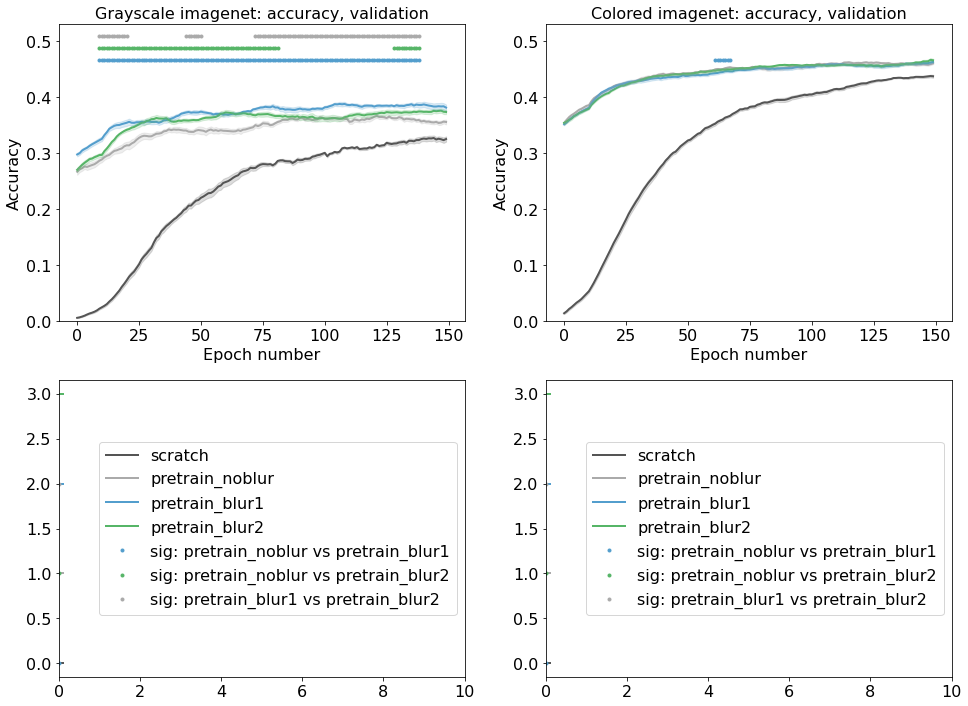

In [7]:

cc2plot = [3,4,5]
comparison_markers = ['.','.','.']
comparison_colors = np.concatenate([blue_colors[1:,:], green_colors[1:,:], gray_colors[1:,:]], axis=0)
# NOTE I am only plotting the comparisons between pre-trained  models here - the control
# model is also significantly diff from each pre-trained model at all timepoints
# but it makes the plot too busy to show it.

ylims = [0.0, 0.53]
ydist = ylims[1]-ylims[0]
sig_positions = ylims[0]+ydist*np.array([0.88, 0.92, 0.96])

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(16)

plt.figure(figsize=(16,12))

pi=0; pi2=0;

for smoothed_val, mask_fdr, name  in zip([smoothed_val_bw, smoothed_val_col],\
                                  [mask_fdr_bw, mask_fdr_col], \
                                        ['Grayscale', 'Colored']):


    pi+=1
   
    plt.subplot(2,2,pi)

    for cc in range(n_conds):

        meanvals = np.mean(smoothed_val[cc,:,:], axis=0)
        semvals = np.std(smoothed_val[cc,:,:], axis=0)/np.sqrt(n_trials)

        plt.plot(epochs_smoothed, meanvals, label = cond_names[cc], linewidth=2, color=cond_colors[cc,:])
        plt.fill_between(epochs_smoothed, meanvals-semvals, meanvals+semvals,
                alpha=0.2, zorder=10, color=cond_colors[cc,:])

    # loop over the different pairwise comparisons that we did
    for ci, ccpair in enumerate(cc2plot):

        is_sig = np.where(mask_fdr[:,ccpair])[0]
        plt.plot(np.array(epoch_centers)[is_sig], sig_positions[ci]*np.ones(np.shape(is_sig)),\
                 linestyle='none', marker=comparison_markers[ci], \
                 color=comparison_colors[ci,:],alpha=1, \
                 label = 'sig: %s'%cond_comparisons[ccpair])

    plt.ylim(ylims)
    # plt.ylim([-0.10, 0.60])
    plt.xlabel('Epoch number')
    plt.ylabel('Accuracy')

    plt.title('%s imagenet: accuracy, validation'%name);

    pi2+=1
    plt.subplot(2,2,pi2+2)

    # plt.subplot(1,2,2)
    for cc in range(n_conds):
        plt.plot([0,0.1], [cc,cc], label = cond_names[cc], linewidth=2, color=cond_colors[cc,:])
    for ci, ccpair in enumerate(cc2plot):
        plt.plot(0,ci,\
                 linestyle='none', marker=comparison_markers[ci], \
                 color=comparison_colors[ci,:],alpha=1, \
                 label = 'sig: %s'%cond_comparisons[ccpair])
    plt.xlim([0,10])
    plt.legend(loc='center right')

fn2save = os.path.join(root, 'analysis', 'figures', 'ImageNet_accuracy_both.pdf')
plt.savefig(fn2save)


#### Compare color and grayscale conditions

In [11]:
mean_timepts_col = np.mean(smoothed_val_col, axis=2)
mean_timepts_bw = np.mean(smoothed_val_bw, axis=2)

n_color_conds=2
condlabels = np.tile(np.repeat(np.arange(n_conds), n_trials), [n_color_conds,])
colorlabels = np.repeat(np.arange(n_color_conds), n_trials*n_conds)
dat = np.concatenate([mean_timepts_bw.ravel(), mean_timepts_col.ravel()])

aov_df = pd.DataFrame({'acc': dat, 'color': colorlabels, 'cond': condlabels})

import statsmodels.stats.anova
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('acc ~ C(color) + C(cond) + C(color):C(cond)', data=aov_df).fit()

statsmodels.stats.anova.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(color),1.0,0.150537,0.150537,4300.129232,5.946969e-66
C(cond),3.0,0.226598,0.075533,2157.613201,2.110365e-70
C(color):C(cond),3.0,0.002640,0.000880,25.140178,3.096969e-11
Residual,72.0,0.002521,0.000035,NaN,NaN


#### Plot learning rates

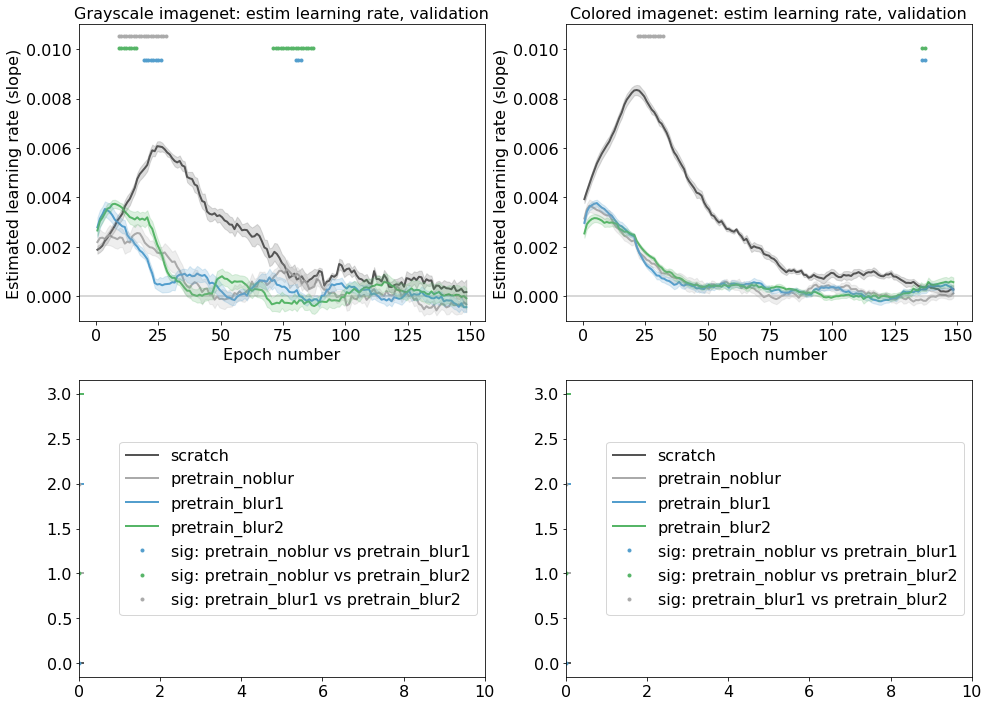

In [8]:

cc2plot = [3,4,5]
comparison_markers = ['.','.','.']
comparison_colors = np.concatenate([blue_colors[1:,:], green_colors[1:,:], gray_colors[1:,:]], axis=0)
# NOTE I am only plotting the comparisons between pre-trained  models here - the control
# model is also significantly diff from each pre-trained model at all timepoints
# but it makes the plot too busy to show it.


ylims = [-0.001, 0.011]
ydist = ylims[1]-ylims[0]
sig_positions = ylims[0]+ydist*np.array([0.88, 0.92, 0.96])

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(16)

plt.figure(figsize=(16,12))

pi=0; pi2=0;
for lr_val_smoothed, mask_fdr_lr, name  in zip([lr_val_smoothed_bw, lr_val_smoothed_col],\
                                  [mask_fdr_lr_bw, mask_fdr_lr_col], \
                                        ['Grayscale', 'Colored']):
    pi+=1
    plt.subplot(2,2,pi)

    for cc in range(n_conds):

        meanvals = np.mean(lr_val_smoothed[cc,:,:], axis=0)
        semvals = np.std(lr_val_smoothed[cc,:,:], axis=0)/np.sqrt(n_trials)

        plt.plot(epochs_lr_smoothed, meanvals, label = cond_names[cc], linewidth=2, color=cond_colors[cc,:])
        plt.fill_between(epochs_lr_smoothed, meanvals-semvals, meanvals+semvals,
                alpha=0.2, zorder=10, color=cond_colors[cc,:])


    # loop over the different pairwise comparisons that we did
    for ci, ccpair in enumerate(cc2plot):

        is_sig = np.where(mask_fdr_lr[:,ccpair])[0]
        plt.plot(np.array(epoch_centers_lr)[is_sig], sig_positions[ci]*np.ones(np.shape(is_sig)),\
                 linestyle='none', marker=comparison_markers[ci], \
                 color=comparison_colors[ci,:],alpha=1, \
                 label = 'sig: %s'%cond_comparisons[ccpair])

    plt.axhline(0,color=[0.8, 0.8, 0.8], zorder=-10)
    plt.ylim(ylims)
    plt.xlabel('Epoch number')
    plt.ylabel('Estimated learning rate (slope)')

    plt.title('%s imagenet: estim learning rate, validation'%name);
    
    pi2+=1
    
    plt.subplot(2,2,pi2+2)
    
    for cc in range(n_conds):
        plt.plot([0,0.1], [cc,cc], label = cond_names[cc], linewidth=2, color=cond_colors[cc,:])
    
    for ci, ccpair in enumerate(cc2plot):

        plt.plot(0,ci,\
                 linestyle='none', marker=comparison_markers[ci], \
                 color=comparison_colors[ci,:],alpha=1, \
                 label = 'sig: %s'%cond_comparisons[ccpair])
    plt.xlim([0,10])
    plt.legend(loc='center right')

fn2save = os.path.join(root, 'analysis', 'figures', 'ImageNet_learningrate_both.pdf')
plt.savefig(fn2save)
